In [170]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [171]:
def model_building(X_train, y_train, X_test, y_test, look_back,scaler): 
                
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
                
    model = Sequential()
    #model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(4,input_shape=(1,look_back)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X_train, y_train, epochs=5, verbose=0)
    
    
    #------ Prediction ------ #
    
    train_predict = model.predict(X_train)
    train_predict = scaler.inverse_transform(train_predict)
    
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(test_predict)
    
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.2f RMSE' % (test_score))

    joined_data = np.concatenate((train_predict,test_predict),axis=0)
    return train_predict, test_predict,joined_data
  

In [172]:
from matplotlib import pyplot as plt
from bokeh.io import output_notebook
output_notebook()

def plotting(trainPredictPlot, testPredictPlot):

    # initialize testPredictPlot with NaN values
    testPredictPlot_empty = np.empty_like(trainPredictPlot)
    testPredictPlot_empty[:] = np.nan
    
    # now concatenate trainPredictPlot with testPredictPlot
    testPredictPlot = np.concatenate((testPredictPlot_empty, testPredictPlot), axis=0)

    
    plt.plot(trainPredictPlot, label='Test set prediction')
    
    plt.plot(testPredictPlot, label='Test set prediction')
    #plt.plot(joined, label='Joined data',color='black')
    plt.legend()

    plt.show()
    

Loading BokehJS ...

In [173]:
def stacked_lstm(financial_data,record_to_plot:int=2000):
    financial_data = financial_data.reset_index()
    financial_data = financial_data[:record_to_plot]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(financial_data['Close']).reshape(-1, 1))
    
    # Splitting dataset into train and test split
    # As we are using time series data, we need to split the data in train and test on the basis of time not just take the first 80% data as train and remaining as test
    
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    print(tscv)
 
    for train_index, test_index in tscv.split(scaled_data):
        
        """train =[]
        test = []
        for i in range(financial_data.shape[0]):
            # add every 5th record to test data and remaining to train data so that we have continuous data in test data
            if i%5 == 0:
                test.append(scaled_data[i])
            else:
                train.append(scaled_data[i])
        #train = scaled_data[:int(0.8*len(scaled_data))]
        #test = scaled_data[int(0.8*len(scaled_data)):]
        
         """
        # convert train and test data to numpy array

        train = scaled_data[train_index]
        test = scaled_data[test_index]
     
        def create_dataset(dataset, look_back:int=0):
            X, Y = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back)]
                X.append(a)
                Y.append(dataset[i + look_back])
            return np.array(X), np.array(Y)
        
        
        lookback = 1
        X_train, y_train = create_dataset(train, lookback)
        X_test, y_test = create_dataset(test, lookback)
        

        
        trainPredictPlot, testPredictPlot,joined = model_building(X_train,y_train,X_test,y_test,lookback,scaler)

        true_data = financial_data['Close']
        plotting(trainPredictPlot, testPredictPlot)
  

In [174]:
financial_data = pd.read_csv(
    "..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [175]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
11/11 [==============================] - 0s 2ms/step
Train Score: 0.08 RMSE
Test Score: 0.05 RMSE


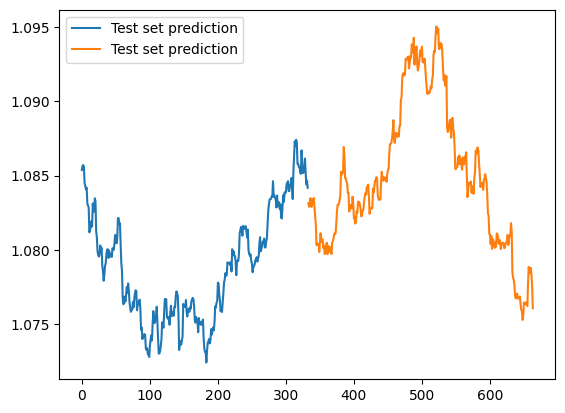

11/11 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Test Score: 0.08 RMSE


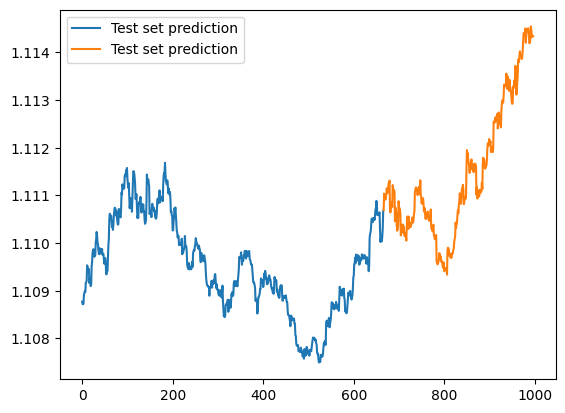

11/11 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Test Score: 0.13 RMSE


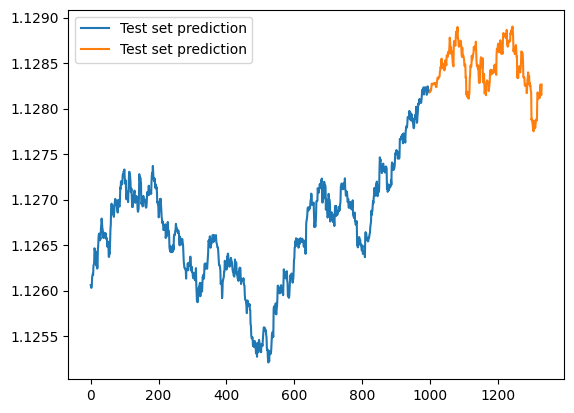

11/11 [==============================] - 0s 2ms/step
Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


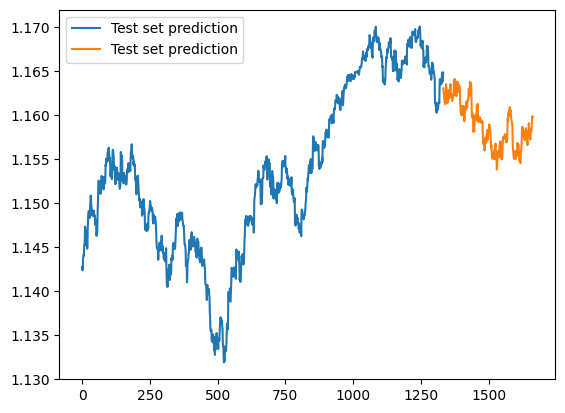

11/11 [==============================] - 0s 2ms/step
Train Score: 0.03 RMSE
Test Score: 0.03 RMSE


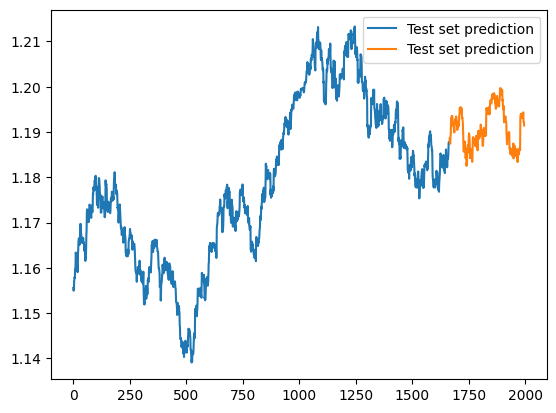

In [176]:
stacked_lstm(financial_data,record_to_plot=2000)
